In [1]:
'''Importing Data Manipulation Moduls'''
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) #Limiting float outputs to 5 decimal points

from scipy import stats

'''Seaborn and Matplotlib Visualization'''
import matplotlib.pyplot as plt  ## importing this package for visualization
import seaborn as sns ## this package gives many awesome functionalities with less efforts
sns.set()
plt.style.use('bmh')                    
sns.set_style({'axes.grid':False}) 
%matplotlib inline

'''plotly Visualization'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True)


'''Ignore deprecation and future, and user warnings.'''
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

'''Standarize numeric features with RobustScaler'''
from sklearn.preprocessing import RobustScaler

## Need to apply below Different techniques:
- Data Extraction is already done, as data was provided by Kaggle
- Data Analysis
    - first understand the Target variable thats your aim to predict
    - understanding outliers in features
        - (here we can aurgue that we don't need to worry about outliers as it can be handled by sklearn RobustScaler techniques) 
        - (There are many other techniques to scale your features RobustScaler is one of them which is not affected by outliers)
        - (Make sure you understand the reason behind scaling the features)
    - understand multi-colinearity among features 
        (here we can have one aurgument that we can impute first and then check multi-colinearity)   
- Data Cleaning (handle missing values, remove unexpected values like house price can't be negative)
    - dummify or imputation
    - analyze data type of features
- Data Filtering or removing not needed data
- Feature Engineering (selecting only important features, using techiniques like lassoCV, RandomForest, etc)
- Data Transformation (create new features if needed)
- Data Load on different ML model
    - Cross Validation
    - fine tune hyperparameters
    - Check can we use PCA for such approaches

## Exploratory Data Analysis for Train and Test dataset

In [2]:
train_originalDF = pd.read_csv("data/train.csv")
test_originalDF = pd.read_csv("data/test.csv")
print(train_originalDF.shape) ## (1460, 81)
print(test_originalDF.shape) ## (1459, 80) ## test dataset doesn't include SalesPrice column

(1460, 81)
(1459, 80)


Does salePrice has any missing values:  False
Does salePrice has any values less than 0:  0
Skewness: 1.882876
Kurtosis: 6.536282

 Before transformation: mu = 180921.20 and sigma = 79415.29



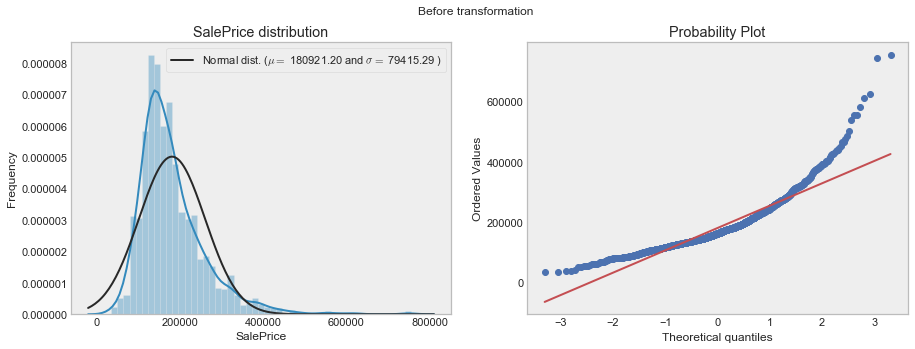


 After transformation: mu = 12.02 and sigma = 0.40



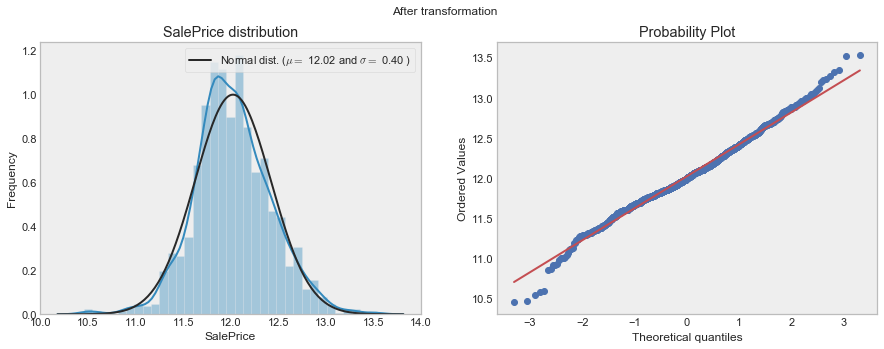

In [3]:
## Lets explore Target variable "SalesPrice" and drop from original dataset

v_SalePrice = train_originalDF['SalePrice']
print("Does salePrice has any missing values: ", v_SalePrice.isnull().any())
print("Does salePrice has any values less than 0: ", v_SalePrice[v_SalePrice<0].size)

#skewness and kurtosis 

## Below are common understanding/ interpretation of skewness 
## https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics

## If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
## If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed
## If the skewness is less than -1 or greater than 1, the data are highly skewed

## Below are common understanding/ interpretation of Kurtosis
## “The kurtosis parameter is a measure of the combined weight of the tails relative to the rest of the distribution.”
## kurtosis of a normal distribution is 0.
## if a dataset has a positive kurtosis, it has more in the tails than the normal distribution. 
## If a dataset has a negative kurtosis, it has less in the tails than the normal distribution. 

## Hence we can conclude that our SalesPrice data is highly skewed towards right and has positive kurtosis means more weight in tails.

print("Skewness: %f" % v_SalePrice.skew()) ## https://en.wikipedia.org/wiki/Skewness
print("Kurtosis: %f" % v_SalePrice.kurt()) ## https://en.wikipedia.org/wiki/Kurtosis

## Lets plot histogram and PDF (probability density curve) for salePrice and understand the pattern

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(v_SalePrice , fit=stats.norm);
(mu, sigma) = stats.norm.fit(v_SalePrice)
print( '\n Before transformation: mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(v_SalePrice, plot=plt)
plt.suptitle('Before transformation')
plt.show() ## Here we can see that salesPrice has right skewness, also known as positive skewness

## In-order to deal with right skewness, we learned that we can apply log transformations to create a normalized dataset, 
## so that we can implement ML models. As ML models perform well with normalized dataset. as per regression model assumptions.

# Apply transformation
v_log_SalePrice = np.log(v_SalePrice) ## Question, whats the impact of applying different logarithmic functions

## Lets plot histogram and PDF (probability density curve) for salePrice and understand the pattern after transformation

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(v_log_SalePrice , fit=stats.norm);
(mu, sigma) = stats.norm.fit(v_log_SalePrice)
print( '\n After transformation: mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(v_log_SalePrice, plot=plt)
plt.suptitle('After transformation')
plt.show() 

# Lets Analyze predictors now

In [4]:
trainDF_noSP = train_originalDF.drop('SalePrice', axis=1)
testDF = test_originalDF.copy()

In [5]:
trainDF_noSP.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.00000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.00000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.00000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Not sure what is the best way to analyze and understand so many features all together
### few techniques from theory comes in my mind
- PCA
- Colinearity check
- individual scatter plot against target for each feature
    - doing individual scatter plot against each feature is very time consuming and seems not feasible. Need to see what else can be done.
- from Kaggle came to know that its better to inspect the residuals plots to detect any non-linear relationships instead of individual scatter plot.
    - need to see how to do that

### The first thing that came in my mind is to find out what are the best suited features for modeling. This can be achieved in multiple ways
- manually analyze the feature in DF or in excel sheet
- lets first plot correlation matrix and understand best co-related features. It feels to me that plotting directly co-relation matrix is not a good idea. 
- we can inspect the type of variables as well and understand it more better.

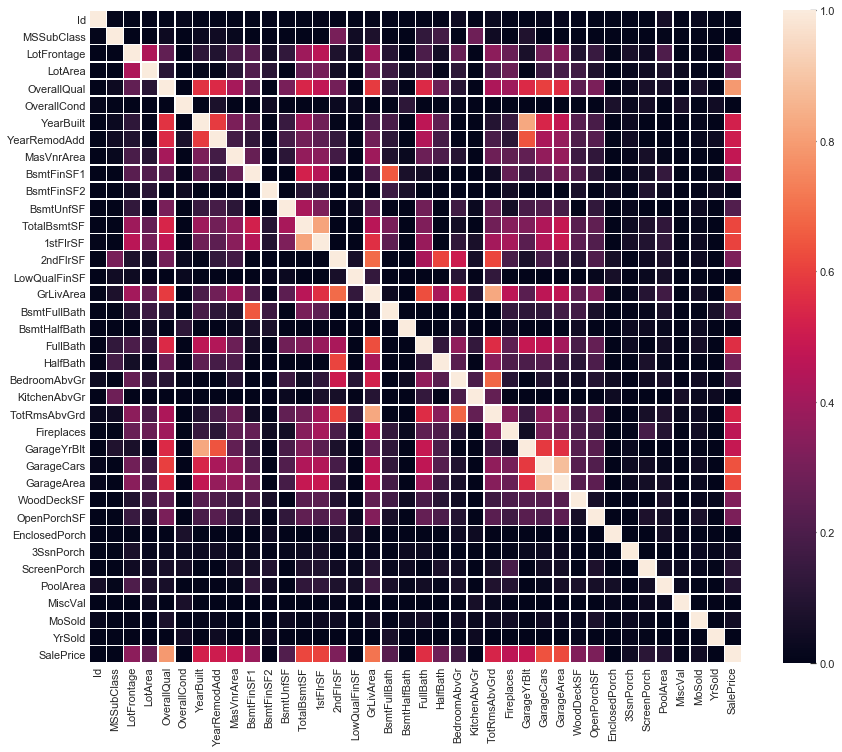

In [6]:
## plotting correlation matrix, as you can see not very helpful
corr = train_originalDF.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr, linewidths=.5, vmin=0, vmax=1, square=True)

In [7]:
## lets find out data type of each feature and analyze it in more detail. This can be done seperately for both train and test set.
display(trainDF_noSP.dtypes.value_counts())

object     43
int64      34
float64    3 
dtype: int64

### Below we created a function to imput all missing values based on our analysis
### All analysis points are also listed in details with the imputation code

In [8]:
## Lets start imputing missing values in the dataset

def impute_fun(dataframe_name):
    # 1. MSZoning is imputed by mode of its values
    # Electrical system has only one missing row and it looks like Missing at Random hence choose mode of it
    # There is only one row with missing 'KitchenQual' details in test dataset and 'KitchenAbvGrd' feture tells us that there is kitchen available in house.
    
    '''These are categorical variables and will be imputed by mode.'''
    to_impute_by_mode =  dataframe_name.loc[:, ['MSZoning', 'Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional']]
    for i in to_impute_by_mode.columns:
        dataframe_name[i].fillna(dataframe_name[i].mode()[0], inplace = True)

    ## 2. LotFrontage needs some analysis and need to look into it later

    '''correlation of df'''
    # corr = dataframe_name.corr()
    #print(corr['LotFrontage'].sort_values(ascending = False)[:5])
    #print(corr['LotFrontage'].sort_values(ascending = False)[-5:])

    ## Looking at this correlation matrix, we can see that "LotFrontage" has high correation with "LotArea", so we can impute the values based on it.
    ## Question, will this brings multi-colinearity issue. We need to deal with it later.

    '''Impute LotFrontage with median of respective columns (i.e., LotArea)'''
    ##dataframe_name['LotFrontage'] = dataframe_name.groupby(['LotArea'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    dataframe_name.drop('LotFrontage', axis=1, inplace=True)
    ## 3. Alley can be easly replace by "None" for all missing values
    ## FireplaceQu has same number of rows with missing values where there is "0" value for FirePlace feature, 
    ## which means Fireplace Quality has missing rows for all the variables where there is no fireplace at all in house
    
    '''These are the features for which we can directly impute "None" for missing values'''
    to_impute_by_none =  dataframe_name.loc[:, ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC','Fence', 'MiscFeature']]
    for i in to_impute_by_none.columns:
        dataframe_name[i].fillna("None", inplace = True)

    ## 4. Utilities has only 2 rows with missing values
    # while looking at the train and test dataset for this feature, it looks like almost 95% of the rows has "AllPub" value. 
    ## Which makes this feature itself unimportant, hence decided to drop this column

    ## print(dataframe_name.groupby('Utilities')['Utilities'].count())
    dataframe_name['Utilities'].fillna(dataframe_name['Utilities'].mode()[0], inplace=True)

    ## 5. Exterior1st and Exterior2nd were corrected by mode

    ## 6. MasVnrType, MasVnrArea
    ## print("Total missing values in MasVnrType:  " ,dataframe_name.MasVnrType.isnull().sum())
    ## print("Total missing values in MasVnrArea:  ", dataframe_name.MasVnrArea.isnull().sum())

    ## Lets now understand one row where MasVnrArea is not null but MasVnrType is.
    dataframe_name[['MasVnrType', 'MasVnrArea']][dataframe_name.MasVnrType.isnull() & dataframe_name.MasVnrArea.notnull()]

    ## Although aftercarefully review MasVnrType, it seems most common value is also None and hence replacing all missing value in 
    ## MasVnrType with None and MasVnrArea with 0
    dataframe_name.loc[:,'MasVnrArea'].fillna(0, inplace = True)

    ## Below we are dealing with all missing values in basement features

    BsmtCols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    idx = dataframe_name.index[dataframe_name[BsmtCols].isnull().all(1)]
    for i in BsmtCols:
        for j in idx:
            dataframe_name.loc[j,i] = "None"

    ## Now lets see how many values are missing in any of the remaining basement columns
    ## these 4 columns 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF' has only one row with missing value and after analyzing 
    ## we realized that it could be 0 as there is no basement for that row

    fillna_bsmt_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
    for i in fillna_bsmt_cols:
        dataframe_name[i].fillna(0.0, inplace = True)


    ## used below lines of code to check nan is basement features
    ## idx2 = dataframe_name.index[dataframe_name[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].isnull().any(1)]
    ## dataframe_name.loc[idx2,['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]


    ## Convert remaining missing values in basement features by mode of it
    to_impute_basement_missing_values_by_mode =  ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    for i in to_impute_basement_missing_values_by_mode:
        dataframe_name[i].fillna(dataframe_name[i].mode()[0], inplace = True)
    
    ## Below code is to handle all missing values for Garage related features
    
    dataframe_name['GarageYrBlt'].fillna(dataframe_name['YearBuilt'], inplace=True) ## this is to replace garage year built with yearbuilt of house
    
    GarCols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
    Gidx = dataframe_name.index[dataframe_name[GarCols].isnull().all(1)] ## lets find out all the rows where all rows has nan
    for i in GarCols:
        for j in Gidx:
            dataframe_name.loc[j,i] = "None"
    
    ## Convert remaining missing values in garage features by mode of it
    to_impute_garage_missing_values_by_mode =  ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars', 'GarageArea', 'SaleType']
    for i in to_impute_garage_missing_values_by_mode:
        dataframe_name[i].fillna(dataframe_name[i].mode()[0], inplace = True)
    

In [9]:
## By running this function we were able to handle missing values
impute_fun(trainDF_noSP)
impute_fun(testDF)

In [10]:
trainDF_noSP.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.00000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal
1,2,20,RL,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal
2,3,60,RL,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal
3,4,70,RL,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml
4,5,60,RL,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal


In [11]:
## In order to analyze any dataset first we need to have complete dataset, means we need to handle missing values

## missing_data frame shows column names, total number of values with NAN, percentage of values and datatype of column 
total = trainDF_noSP.isnull().sum().sort_values(ascending=False)
percent = (trainDF_noSP.isnull().sum()/trainDF_noSP.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#missing_data.head(10)

## Lets handle missing data in each feature one by one
missing_data.loc[trainDF_noSP.columns[:]][missing_data.Total>0]

,Total,Percent


In [12]:
total = testDF.isnull().sum().sort_values(ascending=False)
percent = (testDF.isnull().sum()/testDF.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#missing_data.head(10)

## Lets handle missing data in each feature one by one
missing_data.loc[testDF.columns[:]][missing_data.Total>0]

,Total,Percent


In [13]:
## Lets analysis data type of features, so far we didn't change data type of any feature
display(trainDF_noSP.dtypes.value_counts())

object     43
int64      34
float64    2 
dtype: int64

In [14]:
## its always easy to understand numerical features first and do needed analysis 
train_num = trainDF_noSP.select_dtypes(include = ['int64', 'float64'])
display(train_num.head(3))

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,8450,7,5,2003,2003,196.00000,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.00000,2,548,0,61,0,0,0,0,0,2,2008
1,2,20,9600,6,8,1976,1976,0.00000,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.00000,2,460,298,0,0,0,0,0,0,5,2007
2,3,60,11250,7,5,2001,2002,162.00000,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.00000,2,608,0,42,0,0,0,0,0,9,2008


In [15]:
## lets create new df that contains imputed dataset for numerical features and target variable
new_trainDF_cor = pd.concat([train_num,v_SalePrice], axis=1)

## A very nice article to understand the same - https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

## creating correlation matrix
cor = new_trainDF_cor.corr()
#Correlation with output variable
cor_target = abs(cor["SalePrice"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

OverallQual    0.79098
YearBuilt      0.52290
YearRemodAdd   0.50710
TotalBsmtSF    0.61358
1stFlrSF       0.60585
GrLivArea      0.70862
FullBath       0.56066
TotRmsAbvGrd   0.53372
GarageYrBlt    0.50804
GarageCars     0.64041
GarageArea     0.62343
SalePrice      1.00000
Name: SalePrice, dtype: float64

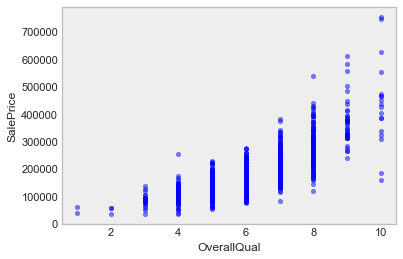

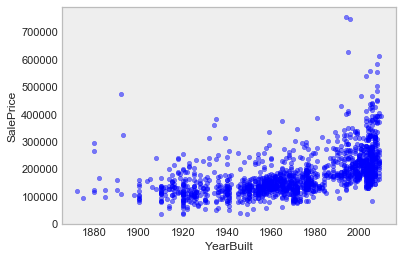

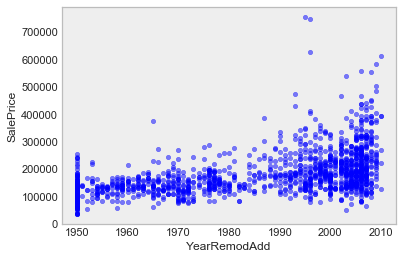

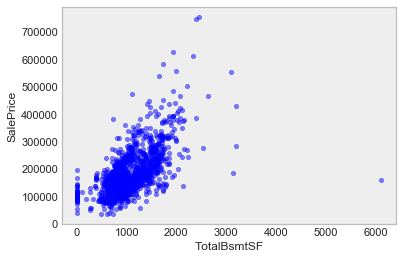

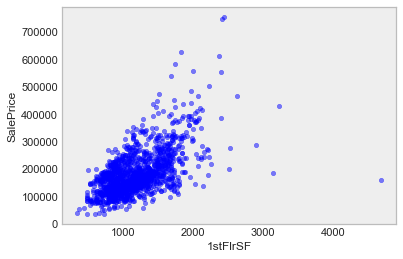

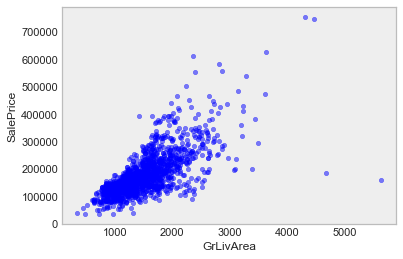

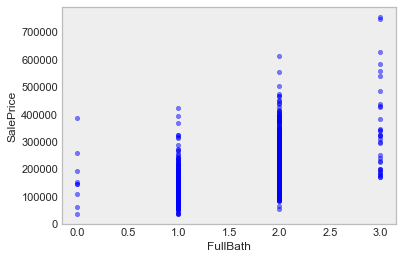

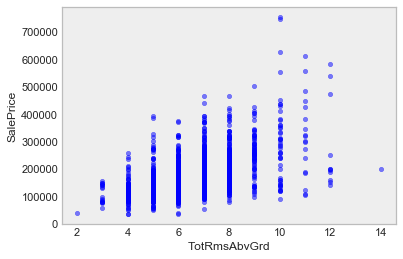

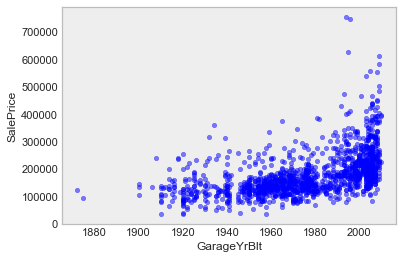

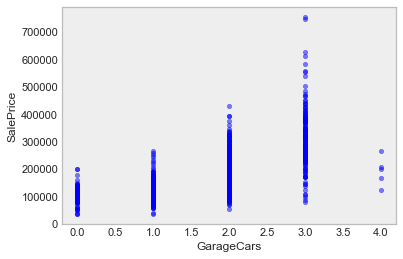

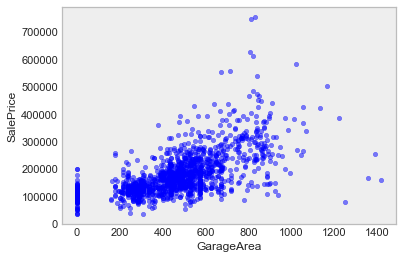

In [16]:
## Now lets create scatter plot for these highly correlated features to understand any outliers or behaviour of these features
cols = relevant_features.index[:-1]
for i in cols:
    data = pd.concat([train_num[i],v_SalePrice], axis=1)
    data.plot.scatter(x=i,y='SalePrice',alpha=0.5)
    plt.show()

## 2. Feature Encoding 
- feature encoding for ordinal categorical features 
    - Soluton: either do manual encoding or use sklearn labelEncoding
- feature encoding for nominal categorical features
    - Solution: best way to do it using sklearn one-hot-ecoding technique or get_dummies function
- feature encoding for discrete numerical features
    - Solution: usually no encoding required
- feature encoding for continuos numerical features
    - solution: usually no encoding required

#### Tasks
- Feature encoding
- deal with outliers
- covert features to the proper data types

In [17]:
## Lets convert below features to object datatypes as these are ordinal features
trainDF_noSP.loc[:,['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold', 'GarageYrBlt']] = trainDF_noSP.loc[:,['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold', 'GarageYrBlt']].astype('int64')
## can we include MoSold, and YrSold also in this

In [18]:
## lets first understand the datatypes of features
trainDF_noSP.dtypes.value_counts()
## float columns are MasVnrArea

object     43
int64      35
float64    1 
dtype: int64

In [19]:
## lets create function to perform label encoding on ordinal features
"""Let's extract categorical variables first and convert them into category data type."""
trainDF_cat = trainDF_noSP.select_dtypes(include = ['object']).apply(lambda x: x.astype('category')) ##.astype('category')
trainDF_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [20]:
## Lets perform ordinal encoding on below fetures
trainDF_cat.Utilities.replace(to_replace = ['ELO', 'NoSewr','NoSeWa', 'AllPub'], value = [0, 1, 2, 3], inplace = True)
trainDF_cat.LandSlope.replace(to_replace = ['Sev', 'Mod', 'Gtl'], value = [0, 1, 2], inplace = True)
trainDF_cat.HouseStyle.replace(to_replace = ['1Story', '1.5Unf',  '1.5Fin', '2Story' , '2.5Unf', '2.5Fin', 'SFoyer', 'SLvl'
                                            ], value = [0, 1, 2, 3, 4, 5, 6, 7], inplace = True)
trainDF_cat.ExterQual.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
trainDF_cat.ExterCond.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
trainDF_cat.BsmtQual.replace(to_replace = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
trainDF_cat.BsmtCond.replace(to_replace = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
trainDF_cat.BsmtExposure.replace(to_replace = ['None', 'No',  'Mn', 'Av', 'Gd'], value = [0, 1, 2, 3, 4], inplace = True)
trainDF_cat.BsmtFinType1.replace(to_replace = ['None',  'Unf', 'LwQ', 'Rec',  'BLQ', 'ALQ', 'GLQ' ], value = [0, 1, 2, 3, 4, 5, 6], 
                                 inplace = True)
trainDF_cat.BsmtFinType2.replace(to_replace = ['None',  'Unf', 'LwQ', 'Rec',  'BLQ', 'ALQ', 'GLQ' ], value = [0, 1, 2, 3, 4, 5, 6], 
                                 inplace = True)
trainDF_cat.HeatingQC.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)

trainDF_cat.CentralAir.replace(to_replace = ['N', 'Y'], value = [0, 1], inplace = True)
trainDF_cat.Electrical.replace(to_replace = ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'], value = [4,3,2,1,0], inplace = True)
trainDF_cat.KitchenQual.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
trainDF_cat.Functional.replace(to_replace = ['Sal','Sev', 'Maj2', 'Maj1',  'Mod',  'Min2', 'Min1',  'Typ' ], 
                               value = [0, 1, 2, 3, 4, 5, 6, 7], inplace = True)
trainDF_cat.FireplaceQu.replace(to_replace = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
trainDF_cat.GarageFinish.replace(to_replace = ['None', 'Unf', 'RFn',  'Fin' ], value = [0, 1, 2, 3], inplace = True)
trainDF_cat.GarageQual.replace(to_replace = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
trainDF_cat.GarageCond.replace(to_replace = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
trainDF_cat.PavedDrive.replace(to_replace = ['N', 'P', 'Y'], value = [0, 1, 2], inplace = True)
trainDF_cat.PoolQC.replace(to_replace = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
trainDF_cat.Fence.replace(to_replace = ['None', 'MnWw', 'GdWo',  'MnPrv', 'GdPrv'], value = [0, 1, 2, 3, 4], inplace = True)


In [21]:
## create a new df for label encoded features
trainDF_label_encoded = trainDF_cat.select_dtypes(['int64'])

In [22]:
## perform one-hot encoding on remaining categorical features
'''Now selecting the nominal vaiables for one hot encording'''
trainDF_one_hot = trainDF_cat.select_dtypes(include=['category'])

"""Let's get the dummies variable"""
trainDF_one_hot = pd.get_dummies(trainDF_one_hot, drop_first=True)

"""Let's concat one hot encoded and label encoded variable together"""
trainDF_encoded = pd.concat([trainDF_one_hot, trainDF_label_encoded], axis=1)

In [23]:
trainDF_encoded.shape

(1460, 158)

## Feature Scaling

In sklearn we have various method like from MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler,Normalizer, QuantileTransformer, PowerTransformer. For more see the documentation

Usually well known for rescaling data, i.e., normalization and standarization. Normalization scales all numeric variables in the range [0,1]. So outliers might be lost. On the other hand, standarization transforms data to have zero mean and unit variance.

Feature scaling helps gradient descent converge faster, thus reducing training time. Its not necessary to standarize the target variable. However, due to the presence of outliers, we would use sklearn's RobustScaler since it is not affected by outliers.

In [24]:
trainDF_num = trainDF_noSP.select_dtypes(include = ['int64', 'float64'])

'''Creating scaler object.'''
scaler = RobustScaler()

'''Fit scaler object on train data.'''
scaler.fit(trainDF_num)

'''Apply scaler object to both train and test data.'''
trainDF_scaled = scaler.transform(trainDF_num)

'''Retrive column names'''
trainDF_scaled = pd.DataFrame(data = trainDF_scaled, columns = trainDF_num.columns, index = trainDF_num.index)
# Pass the index of index df_merged_num, otherwise it will sum up the index.

'''Finally join processed categorical and numerical variables'''
trainDF_processed = pd.concat([trainDF_scaled, trainDF_encoded], axis=1)

'''Dimensions of new data frame'''
trainDF_processed.shape

(1460, 194)

In [25]:
'''set a seed for reproducibility'''
seed = 44

'''Initialize all the regesssion models object we are interested in'''
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

''''We are interested in the following 14 regression models.
All initialized with default parameters except random_state and n_jobs.'''
lr = LinearRegression(n_jobs = -1)
lasso = Lasso(random_state = seed)
ridge = Ridge(random_state = seed)
elnt = ElasticNet(random_state = seed)
kr = KernelRidge()
dt = DecisionTreeRegressor(random_state = seed)
svr = SVR()
knn = KNeighborsRegressor(n_jobs= -1)
pls = PLSRegression()
rf = RandomForestRegressor(n_jobs = -1, random_state = seed)
et = ExtraTreesRegressor(n_jobs = -1, random_state = seed)
ab = AdaBoostRegressor(random_state = seed)
gb = GradientBoostingRegressor(random_state = seed)
xgb = XGBRegressor(n_jobs = -1, random_state = seed)
#lgb = LGBMRegressor(n_jobs = -1, random_state = seed)

In [26]:
'''Function to plot scatter plot'''
def scatter_plot(x, y, title, xaxis, yaxis, size, c_scale):
    trace = go.Scatter(x = x,
                        y = y,
                        mode = 'markers',
                        marker = dict(color = y, size=size, showscale = True, colorscale = c_scale))
    layout = go.Layout(hovermode = 'closest', title = title, xaxis = dict(title = xaxis), yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)

In [27]:
'''Evaluate model on the train set data frame'''
def train_test_split(model):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    X_train, X_test, Y_train, Y_test = train_test_split(trainDF_processed, v_log_SalePrice, test_size = 0.3, random_state = seed)
    model.fit(X_train, Y_train)
    prediction = model.predict(X_test)
    mse = mean_squared_error(prediction, Y_test)
    rmse = np.sqrt(mse) #non-negative square-root
    return rmse

'''Calculate train_test_split score of differnt models and plot them.'''
models = [lasso, ridge, elnt, kr, dt, svr, knn, pls, rf, et, ab, gb, xgb]
train_test_split_rmse = []
for model in models:
    train_test_split_rmse.append(train_test_split(model))

'''Plot data frame of train test rmse'''
train_test_score = pd.DataFrame(data = train_test_split_rmse, columns = ['Train_Test_RMSE'])
train_test_score.index = ['LASSO',  'RIDGE', 'ELNT', 'KR', 'DT', 'SVR', 'KNN', 'PLS', 'RF', 'ET', 'AB', 'GB', 'XGB']
scatter_plot(train_test_score.index, train_test_score['Train_Test_RMSE'], "Models' Test Score (RMSE) on Holdout(30%) Set", 'Models', 'RMSE', 30, 'plotly3')

[12:07:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Lets perform cross validation to overcome bias that is raised by train_test_split process

In [28]:
'''Function to compute cross validation scores.'''
def cross_validation(model):
    from sklearn.model_selection import cross_val_score
    val_score = cross_val_score(model, trainDF_processed, v_log_SalePrice, cv=10, n_jobs= -1, scoring = 'neg_mean_squared_error')
    sq_val_score = np.sqrt(-1*val_score)
    r_val_score = np.round(sq_val_score, 5)
    return r_val_score.mean()

'''Calculate cross validation score of differnt models and plot them.'''
models = [lasso, ridge, elnt, kr, dt, svr, knn, pls, rf, et, ab, gb, xgb]
cross_val_scores = []
for model in models:
    cross_val_scores.append(cross_validation(model))

'''Plot data frame of cross validation scores.'''
x_val_score = pd.DataFrame(data = cross_val_scores, columns=['Cross_Val_Score(RMSE)'])
x_val_score.index = ['LASSO',  'RIDGE', 'ELNT', 'KR', 'DT', 'SVR', 'KNN', 'PLS', 'RF', 'ET', 'AB', 'GB', 'XGB']
scatter_plot(x_val_score.index, x_val_score['Cross_Val_Score(RMSE)'], "Models' 10-fold Cross Validation Scores (RMSE)", 'Models', 'RMSE', 30, 'cividis')

### Model parameter optimizations

In [29]:
## Lets us GridSearch cross validation approach to perform this activity
'''Create a function to tune hyperparameters of the selected models.'''
def tune_hyperparameters(model, param_grid):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score #if you want to know best parametes and best score
    
    '''Construct grid search object with 10 fold cross validation.'''
    grid = GridSearchCV(model, param_grid, cv = 10, verbose = 1, scoring = 'neg_mean_squared_error', n_jobs = -1)
    grid.fit(trainDF_processed, v_log_SalePrice)
    best_params = grid.best_params_ 
    best_score = np.round(np.sqrt(-1 * grid.best_score_), 5)
    return best_params, best_score

### Lets optimize few selected models one by one

### Lasso Model optimization

In [31]:
alpha = [0.0003, 0.0004, 0.00045, 0.0005, 0.00055, 0.0006, 0.00065, 0.0007, 0.00075,0.00078, 0.0008, 0.00082,  0.00085, 0.0009, 0.00095, 0.001, 0.002, 0.005, 0.007, 0.008]

lasso_params = {'alpha': alpha, 'random_state':[seed]}

tune_hyperparameters(lasso, lasso_params)
lasso_best_params, lasso_best_score = best_params, best_score
print('Lasso best params:{} & best_score:{:0.5f}' .format(lasso_best_params, lasso_best_score))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s


Lasso best params:{'alpha': 0.0008, 'random_state': 44} & best_score:0.13996


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    7.4s finished


### Ridge Model Optimization

In [36]:
'''Difine hyperparameters of ridge'''
ridge_param_grid = {'alpha':[8, 9, 10, 11.0, 12, 14.50, 14.68, 14.78, 15, 15.50, 17, 20],
                    'random_state':[seed]}
tune_hyperparameters(ridge, ridge_param_grid)
ridge_best_params, ridge_best_score = best_params, best_score
print('Ridge best params:{} & best_score:{:0.5f}' .format(ridge_best_params, ridge_best_score))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Ridge best params:{'alpha': 14.68, 'random_state': 44} & best_score:0.13957


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.9s finished


### Elastic Net Model Optimization

In [37]:
elastic_params_grid = {'alpha': [0.0001,0.0002, 0.0003, 0.01,0.1,2], 
                 'l1_ratio': [0.2, 0.85, 0.95,0.98,10, 11, 12, 15],
                 'random_state':[seed]}
tune_hyperparameters(elnt, elastic_params_grid)
elastic_best_params, elastic_best_score = best_params, best_score
print('Elastic Net best params:{} & best_score:{:0.5f}' .format(elastic_best_params, elastic_best_score))

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.2s


Elastic Net best params:{'alpha': 0.0001, 'l1_ratio': 12, 'random_state': 44} & best_score:0.14056


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   28.4s finished


### SVR (Support Vector Regressor) Optimization

## Didn't run below code due to computation and time complexity

svr_params_grid = {'kernel':['linear', 'poly', 'rbf'],
                   'C':[2,4,5],
                   'gamma':[0.01,0.001,0.0001]}
tune_hyperparameters(svr, svr_params_grid)
svr_best_params, svr_best_score = best_params, best_score
print('SVR best params:{} & best_score:{:0.5f}' .format(svr_best_params, svr_best_score))

### Random Forest Regressor Optimization

## Didn't run below code due to computation and time complexity
rf_params_grid = {'n_estimators':[1,5,50,100],
                   'max_depth':[1,2],
                   'min_samples_split':[3,4],
                   'min_samples_leaf':[2,4],
                   'random_state':[seed]}
tune_hyperparameters(rf, rf_params_grid)
rf_best_params, rf_best_score = best_params, best_score
print('RF best params:{} & best_score:{:0.5f}' .format(rf_best_params, rf_best_score))

### XGBoost Regressor Optimization

In [40]:
xgb_params_grid = {'min_child_weight': [5, 10],
                   'gamma': [0.04, 0.1, 1.5],
                   'subsample': [0.6, 0.8, 1.0],
                   'colsample_bytree': [0.46, 1.0],
                   'max_depth': [3, 4]}
xgb_opt = XGBRegressor(learning_rate = 0.03, reg_alpha = 0.4640, reg_lambda = 0.8571, n_estimators = 1000, 
                       silent = 1, nthread = -1, random_state = 101)

tune_hyperparameters(xgb_opt, xgb_params_grid)
xgb_best_params, xgb_best_score = best_params, best_score
print('XGB best params:{} & best_score:{:0.5f}' .format(xgb_best_params, xgb_best_score))

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 59.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 114.6min finished


XGB best params:{'colsample_bytree': 0.46, 'gamma': 0.04, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6} & best_score:0.12324


### Gradient Boost Regressor optimization

In [38]:
'''Not Optimize Randomly choosen parameters'''
'''Hyperparameters of gb'''
gb_opt = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = 'sqrt',
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = 'huber', random_state = seed)

'''We can assume this model best score is equal to cross validation scores.
Thought it might not be precise, but I will take it'''
gb_best_score = cross_validation(gb_opt)

In [39]:
print('GB best_score:{:0.5f}' .format(gb_best_score))

GB best_score:0.11923


### lets see the optimized models in plot

In [41]:
"""Let's plot the models' rmse after optimization."""
optimized_scores = pd.DataFrame({'Optimized Scores':np.round([lasso_best_score, ridge_best_score, 
                  elastic_best_score, xgb_best_score, gb_best_score], 5)})
optimized_scores.index = ['Lasso', 'Ridge', 'E_net', 'XGB', 'GB']
optimized_scores.sort_values(by = 'Optimized Scores')
scatter_plot(optimized_scores.index, optimized_scores['Optimized Scores'], "Models' Scores after Optimization", 'Models','Optimized Scores', 40, 'Rainbow')

### lets now collect all best parameter for each model and predict the output values

In [ ]:
'''Initialize 9 object models with best hyperparameters'''
lasso_opt = Lasso(**lasso_best_params)
ridge_opt = Ridge(**ridge_best_params)
elastic_net_opt = ElasticNet(**elastic_best_params)
#rf_opt = RandomForestRegressor(**rf_best_params)
#svm_opt = SVR(**svr_best_params)
xgb_opt = XGBRegressor(**xgb_best_params)
gb_opt = gb_opt

In [ ]:
'''Now train and predict with optimized models'''
def predict_with_optimized_models(model):
    model.fit(df_train_final, y_train)
    y_pred = np.expm1(model.predict(df_test_final))
    submission = pd.DataFrame()
    submission['Id']= test.Id
    submission['SalePrice'] = y_pred
    return submission

'''Make submission with optimized lasso, ridge, kernel_ridge, elastic_net and svm, xgb, gb, and lgb.'''
predict_with_optimized_models(lasso_opt).to_csv('lasso_optimized.csv', index = False)
predict_with_optimized_models(ridge_opt).to_csv('ridge_optimized.csv', index = False)
predict_with_optimized_models(elastic_net_opt).to_csv('elastic_net_optimized.csv', index = False)
#predict_with_optimized_models(rf_opt).to_csv('rf_opt_optimized.csv', index = False)
#predict_with_optimized_models(svm_opt).to_csv('svm_opt_optimized.csv', index = False)
predict_with_optimized_models(xgb_opt).to_csv('xgb_optimized.csv', index = False)
predict_with_optimized_models(gb_opt).to_csv('gb_optimized.csv', index = False)

### List of all the questions that we need to discuss
1. whats the impact of applying different logarithmic functions? for example, in above SalePrice transformation I applied log only instead of log1p
2. Whats the purpose of probability plot here? Why do we need it?
3. Should we first work on missing data imputation or should we first create scatter plot / correlation plot and understand the relationship between predictors vs target variables. Should we impute missing value first or should we remove outliers first and then impute missing values.
4. Need to understand how labelEncoder works.
5. Not sure why this "https://www.kaggle.com/vikassingh1996/extensive-data-preprocessing-and-modeling" article said, LotFrontage is related to "BldgType". As per my understanding its related to "LotArea". Does Imputing "LotFrontage" based on "LotArea" can bring multi-colinearity issue. Do we need to deal with it later using LabelEncoder technique.
6. Not sure why LotFrontage is related to "Neighbourhood". 
7. Should we drop any columns or not?? As we can also do feature selection using Lasso, PCA, etc.
8. what does negative correlation coefficient refers to??
9. What is Pearson correlation ??

- Missing Not At Random --> worst --> example of weight dataset where people not interested in sharing there info
- Missing at random --> --> weights by gender, and looks like gender influence the weight data
- Missing completely at random --> best --> because it can be infer from dataset or there values has no relation with any other variable. 